随机森林非线性关系分析
使用分号作为分隔符成功加载数据
数据形状: (12936, 16)
使用以下列进行分析:
  - 日期列: Date
  - 情感列: Compound_Score
  - 价格列: Close
转换日期列 'Date' 为日期时间类型...

创建特征...
清洗后的数据形状: (11721, 39)

情景1: 使用情感及其特征预测价格
情感预测价格的交叉验证R²得分: -5.9664

情感特征重要性:
                         特征       重要性
11  sentiment_volatility_14  0.190484
9           sentiment_ma_14  0.133438
10   sentiment_volatility_7  0.091126
7            sentiment_ma_3  0.071771
8            sentiment_ma_7  0.069368
6           sentiment_lag_7  0.067790
5           sentiment_lag_6  0.066030
4           sentiment_lag_5  0.064958
2           sentiment_lag_3  0.064005
3           sentiment_lag_4  0.062229
0           sentiment_lag_1  0.059727
1           sentiment_lag_2  0.059073


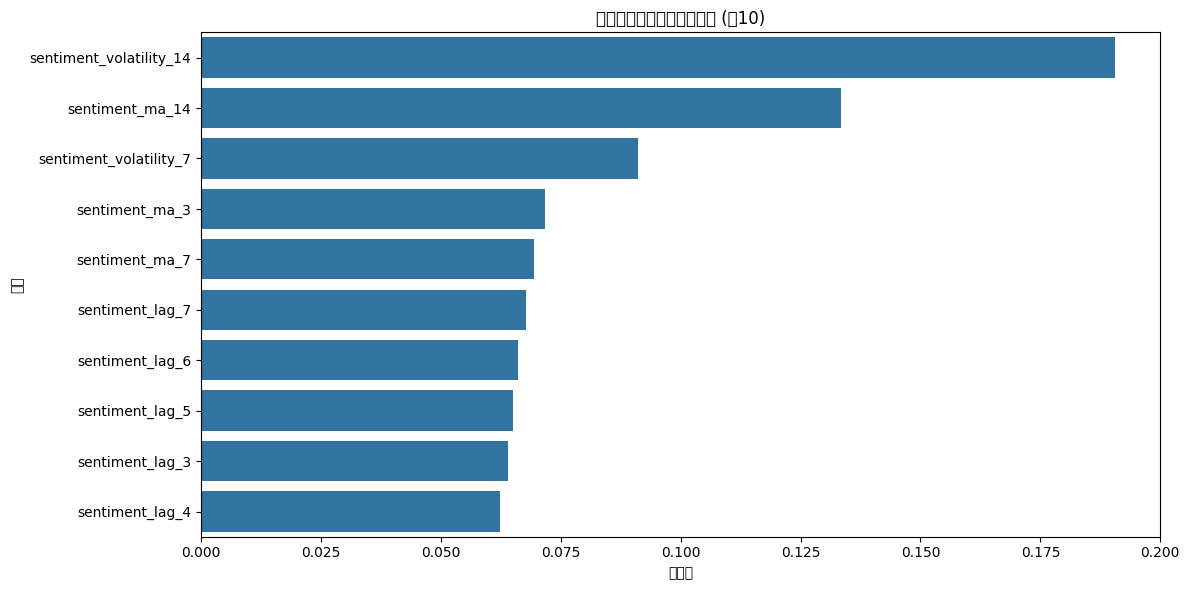


情景2: 使用价格及其特征预测情感
价格预测情感的交叉验证R²得分: -0.3186

价格特征重要性:
                     特征       重要性
12  price_volatility_14  0.200323
11   price_volatility_7  0.101876
10          price_ma_14  0.098014
8            price_ma_3  0.086710
9            price_ma_7  0.077861
3           price_lag_3  0.071878
7           price_lag_7  0.061355
0                  Open  0.054682
6           price_lag_6  0.054125
2           price_lag_2  0.053302
5           price_lag_5  0.051200
4           price_lag_4  0.049551
1           price_lag_1  0.039124


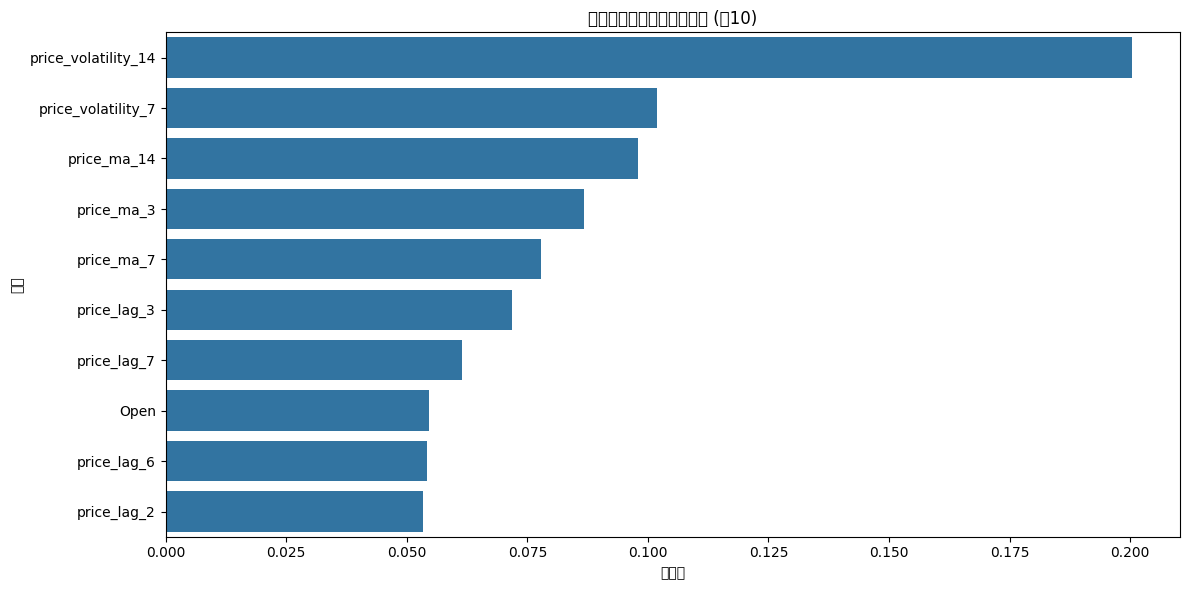


模型比较总结:
1. 情感预测价格模型性能与价格预测情感模型性能的比较可以帮助我们理解数据中的主导因果关系


In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def random_forest_analysis(filepath):
    """
    使用随机森林模型探索价格和情感之间的非线性关系
    
    参数:
    filepath: 数据文件路径
    """
    print("="*80)
    print("随机森林非线性关系分析")
    print("="*80)
    
    # 加载数据
    try:
        # 尝试不同的分隔符
        try:
            df = pd.read_csv(filepath, sep=';', encoding='utf-8')
            print(f"使用分号作为分隔符成功加载数据")
        except:
            df = pd.read_csv(filepath, encoding='utf-8')
            print(f"使用默认分隔符成功加载数据")
        
        print(f"数据形状: {df.shape}")
    except Exception as e:
        print(f"加载数据失败: {e}")
        return None
    
    # 查找关键列
    date_cols = [col for col in df.columns if any(term in col.lower() for term in ['date', 'time'])]
    sentiment_cols = [col for col in df.columns if any(term in col.lower() for term in 
                     ['sentiment', 'compound', 'score', 'positive', 'negative'])]
    price_cols = [col for col in df.columns if any(term in col.lower() for term in 
                 ['price', 'close', 'open', 'high', 'low'])]
    
    # 验证找到了必要的列
    if not (date_cols and sentiment_cols and price_cols):
        print("缺少必要的列（日期、情感或价格）。请检查数据结构。")
        print("可用列: ", df.columns.tolist())
        return None
    
    # 选择要使用的主要列
    date_col = date_cols[0]
    sentiment_col = [col for col in sentiment_cols if 'compound' in col.lower() or 'score' in col.lower()]
    sentiment_col = sentiment_col[0] if sentiment_col else sentiment_cols[0]
    price_col = [col for col in price_cols if 'close' in col.lower()]
    price_col = price_col[0] if price_col else price_cols[0]
    
    print(f"使用以下列进行分析:")
    print(f"  - 日期列: {date_col}")
    print(f"  - 情感列: {sentiment_col}")
    print(f"  - 价格列: {price_col}")
    
    # 确保日期列是日期时间类型
    if df[date_col].dtype != 'datetime64[ns]':
        print(f"转换日期列 '{date_col}' 为日期时间类型...")
        try:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        except Exception as e:
            print(f"日期转换失败: {e}")
            return None
    
    # 按日期排序
    df = df.sort_values(by=date_col)
    
    # 创建特征
    print("\n创建特征...")
    
    # 设置日期为索引
    df.set_index(date_col, inplace=True)
    
    # 创建滞后特征
    for i in range(1, 8):  # 使用7天的滞后
        df[f'price_lag_{i}'] = df[price_col].shift(i)
        df[f'sentiment_lag_{i}'] = df[sentiment_col].shift(i)
    
    # 创建移动平均特征
    for window in [3, 7, 14]:
        df[f'price_ma_{window}'] = df[price_col].rolling(window).mean()
        df[f'sentiment_ma_{window}'] = df[sentiment_col].rolling(window).mean()
    
    # 创建波动率特征
    for window in [7, 14]:
        df[f'price_volatility_{window}'] = df[price_col].rolling(window).std()
        df[f'sentiment_volatility_{window}'] = df[sentiment_col].rolling(window).std()
    
    # 删除NaN值
    df_clean = df.dropna()
    print(f"清洗后的数据形状: {df_clean.shape}")
    
    # 准备模型数据
    # 情景1: 使用情感预测价格
    print("\n情景1: 使用情感及其特征预测价格")
    
    # 选择特征列 - 情感相关
    sentiment_features = [col for col in df_clean.columns if 'sentiment' in col.lower() and col != sentiment_col]
    X_sentiment = df_clean[sentiment_features]
    y_price = df_clean[price_col]
    
    # 数据标准化
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_sentiment_scaled = scaler_X.fit_transform(X_sentiment)
    y_price_scaled = scaler_y.fit_transform(y_price.values.reshape(-1, 1)).ravel()
    
    # 划分训练集和测试集 - 使用时间序列分割
    tscv = TimeSeriesSplit(n_splits=5)
    
    # 随机森林模型
    rf_model_sentiment_to_price = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # 使用时间序列交叉验证
    cv_scores = []
    for train_index, test_index in tscv.split(X_sentiment_scaled):
        X_train, X_test = X_sentiment_scaled[train_index], X_sentiment_scaled[test_index]
        y_train, y_test = y_price_scaled[train_index], y_price_scaled[test_index]
        
        # 训练模型
        rf_model_sentiment_to_price.fit(X_train, y_train)
        
        # 预测
        y_pred = rf_model_sentiment_to_price.predict(X_test)
        
        # 计算得分
        score = r2_score(y_test, y_pred)
        cv_scores.append(score)
    
    print(f"情感预测价格的交叉验证R²得分: {np.mean(cv_scores):.4f}")
    
    # 特征重要性
    feature_importance = pd.DataFrame({
        '特征': X_sentiment.columns,
        '重要性': rf_model_sentiment_to_price.feature_importances_
    }).sort_values('重要性', ascending=False)
    
    print("\n情感特征重要性:")
    print(feature_importance)
    
    # 可视化特征重要性
    plt.figure(figsize=(12, 6))
    sns.barplot(x='重要性', y='特征', data=feature_importance.head(10))
    plt.title('预测价格的情感特征重要性 (前10)')
    plt.tight_layout()
    plt.show()
    
    # 情景2: 使用价格预测情感
    print("\n情景2: 使用价格及其特征预测情感")
    
    # 选择特征列 - 价格相关
    price_features = [col for col in df_clean.columns if any(term in col.lower() for term in ['price', 'close', 'open']) and col != price_col]
    X_price = df_clean[price_features]
    y_sentiment = df_clean[sentiment_col]
    
    # 数据标准化
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_price_scaled = scaler_X.fit_transform(X_price)
    y_sentiment_scaled = scaler_y.fit_transform(y_sentiment.values.reshape(-1, 1)).ravel()
    
    # 随机森林模型
    rf_model_price_to_sentiment = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # 使用时间序列交叉验证
    cv_scores = []
    for train_index, test_index in tscv.split(X_price_scaled):
        X_train, X_test = X_price_scaled[train_index], X_price_scaled[test_index]
        y_train, y_test = y_sentiment_scaled[train_index], y_sentiment_scaled[test_index]
        
        # 训练模型
        rf_model_price_to_sentiment.fit(X_train, y_train)
        
        # 预测
        y_pred = rf_model_price_to_sentiment.predict(X_test)
        
        # 计算得分
        score = r2_score(y_test, y_pred)
        cv_scores.append(score)
    
    print(f"价格预测情感的交叉验证R²得分: {np.mean(cv_scores):.4f}")
    
    # 特征重要性
    feature_importance = pd.DataFrame({
        '特征': X_price.columns,
        '重要性': rf_model_price_to_sentiment.feature_importances_
    }).sort_values('重要性', ascending=False)
    
    print("\n价格特征重要性:")
    print(feature_importance)
    
    # 可视化特征重要性
    plt.figure(figsize=(12, 6))
    sns.barplot(x='重要性', y='特征', data=feature_importance.head(10))
    plt.title('预测情感的价格特征重要性 (前10)')
    plt.tight_layout()
    plt.show()
    
    # 模型比较
    print("\n模型比较总结:")
    print("1. 情感预测价格模型性能与价格预测情感模型性能的比较可以帮助我们理解数据中的主导因果关系")
    
    return {
        'rf_model_sentiment_to_price': rf_model_sentiment_to_price,
        'rf_model_price_to_sentiment': rf_model_price_to_sentiment,
        'sentiment_features': sentiment_features,
        'price_features': price_features
    }

# 调用函数进行随机森林分析
rf_results = random_forest_analysis('../dataset/df_Final.csv')